In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


################################################################################
# Attention Residual U-Net (Attention ResUNet)
################################################################################

# 1. Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

# 2. Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        
        # Shortcut if input and output channels differ
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

# 3. Upsampling Block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        return self.up(x)

# 4. Attention Block
class AttentionBlock(nn.Module):
    """
    The AttentionBlock computes an attention coefficient for a gating signal (g) and a skip
    connection (x), then applies it to x. This is based on the "Attention U-Net" paper.
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        
        # First set of 1x1 convolutions
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int),
        )
        
        # Psi (ψ) to generate attention map
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # g is the gating signal, x is the skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi

# 5. Attention Residual U-Net Model
class AttentionResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionResUNet, self).__init__()
        
        # ----------------- Encoder -----------------
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # ----------------- Bridge -----------------
        self.bridge = ConvBlock(512, 1024)
        
        # ----------------- Decoder -----------------
        # (Gating signal is typically the up-sampled feature from a deeper layer)
        self.up4 = UpConv(1024, 512)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = ResidualBlock(1024, 512)

        self.up3 = UpConv(512, 256)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = UpConv(256, 128)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = UpConv(128, 64)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = ConvBlock(128, 64)
        
        # ----------------- Output -----------------
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bridge
        b  = self.bridge(self.pool4(e4))

        # Decoder level 4
        d4_up = self.up4(b)
        e4_att = self.att4(d4_up, e4)
        d4 = torch.cat((e4_att, d4_up), dim=1)
        d4 = self.dec4(d4)
        
        # Decoder level 3
        d3_up = self.up3(d4)
        e3_att = self.att3(d3_up, e3)
        d3 = torch.cat((e3_att, d3_up), dim=1)
        d3 = self.dec3(d3)
        
        # Decoder level 2
        d2_up = self.up2(d3)
        e2_att = self.att2(d2_up, e2)
        d2 = torch.cat((e2_att, d2_up), dim=1)
        d2 = self.dec2(d2)
        
        # Decoder level 1
        d1_up = self.up1(d2)
        e1_att = self.att1(d1_up, e1)
        d1 = torch.cat((e1_att, d1_up), dim=1)
        d1 = self.dec1(d1)

        # Final
        out = self.final(d1)
        return out

Using device: cuda
Loading data...


100%|██████████| 110/110 [00:02<00:00, 40.25it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.86it/s]


Epoch 1/100 - Train Loss: 0.4846, Train Dice Loss: 0.9728, Val Loss: 0.4615, Val Dice Loss: 0.9619
Saved best model with validation loss: 0.4615


Epoch 2/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 2/100 - Train Loss: 0.4474, Train Dice Loss: 0.9603, Val Loss: 0.4401, Val Dice Loss: 0.9511
Saved best model with validation loss: 0.4401


Epoch 3/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 3/100 - Train Loss: 0.4298, Train Dice Loss: 0.9490, Val Loss: 0.4200, Val Dice Loss: 0.9388
Saved best model with validation loss: 0.4200


Epoch 4/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 4/100 - Train Loss: 0.4172, Train Dice Loss: 0.9388, Val Loss: 0.4063, Val Dice Loss: 0.9322
Saved best model with validation loss: 0.4063


Epoch 5/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 5/100 - Train Loss: 0.3999, Train Dice Loss: 0.9149, Val Loss: 0.3893, Val Dice Loss: 0.9072
Saved best model with validation loss: 0.3893


Epoch 6/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 6/100 - Train Loss: 0.3805, Train Dice Loss: 0.8817, Val Loss: 0.3715, Val Dice Loss: 0.8547
Saved best model with validation loss: 0.3715


Epoch 7/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 7/100 - Train Loss: 0.3573, Train Dice Loss: 0.8366, Val Loss: 0.3406, Val Dice Loss: 0.8096
Saved best model with validation loss: 0.3406


Epoch 8/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 8/100 - Train Loss: 0.3268, Train Dice Loss: 0.7702, Val Loss: 0.3215, Val Dice Loss: 0.7504
Saved best model with validation loss: 0.3215


Epoch 9/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 9/100 - Train Loss: 0.2943, Train Dice Loss: 0.6950, Val Loss: 0.2932, Val Dice Loss: 0.7015
Saved best model with validation loss: 0.2932


Epoch 10/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 10/100 - Train Loss: 0.2557, Train Dice Loss: 0.6030, Val Loss: 0.2534, Val Dice Loss: 0.5981
Saved best model with validation loss: 0.2534


Epoch 11/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 11/100 - Train Loss: 0.2237, Train Dice Loss: 0.5244, Val Loss: 0.2559, Val Dice Loss: 0.6071
EarlyStopping counter: 1 out of 10


Epoch 12/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 12/100 - Train Loss: 0.1904, Train Dice Loss: 0.4448, Val Loss: 0.2462, Val Dice Loss: 0.5808
Saved best model with validation loss: 0.2462


Epoch 13/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 13/100 - Train Loss: 0.1734, Train Dice Loss: 0.4017, Val Loss: 0.1848, Val Dice Loss: 0.4368
Saved best model with validation loss: 0.1848


Epoch 14/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 14/100 - Train Loss: 0.1587, Train Dice Loss: 0.3649, Val Loss: 0.1693, Val Dice Loss: 0.3934
Saved best model with validation loss: 0.1693


Epoch 15/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.84it/s]


Epoch 15/100 - Train Loss: 0.1366, Train Dice Loss: 0.3122, Val Loss: 0.1522, Val Dice Loss: 0.3561
Saved best model with validation loss: 0.1522


Epoch 16/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 16/100 - Train Loss: 0.1330, Train Dice Loss: 0.3035, Val Loss: 0.1521, Val Dice Loss: 0.3538
Saved best model with validation loss: 0.1521


Epoch 17/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 17/100 - Train Loss: 0.1308, Train Dice Loss: 0.2963, Val Loss: 0.1463, Val Dice Loss: 0.3388
Saved best model with validation loss: 0.1463


Epoch 18/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 18/100 - Train Loss: 0.1196, Train Dice Loss: 0.2705, Val Loss: 0.1416, Val Dice Loss: 0.3298
Saved best model with validation loss: 0.1416


Epoch 19/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 19/100 - Train Loss: 0.1218, Train Dice Loss: 0.2747, Val Loss: 0.1369, Val Dice Loss: 0.3194
Saved best model with validation loss: 0.1369


Epoch 20/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.53it/s]


Epoch 20/100 - Train Loss: 0.1160, Train Dice Loss: 0.2619, Val Loss: 0.1369, Val Dice Loss: 0.3165
Saved best model with validation loss: 0.1369


Epoch 21/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.17it/s]


Epoch 21/100 - Train Loss: 0.1123, Train Dice Loss: 0.2531, Val Loss: 0.1285, Val Dice Loss: 0.2986
Saved best model with validation loss: 0.1285


Epoch 22/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.02it/s]


Epoch 22/100 - Train Loss: 0.1041, Train Dice Loss: 0.2337, Val Loss: 0.1541, Val Dice Loss: 0.3537
EarlyStopping counter: 1 out of 10


Epoch 23/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  6.97it/s]


Epoch 23/100 - Train Loss: 0.1052, Train Dice Loss: 0.2355, Val Loss: 0.1515, Val Dice Loss: 0.3485
EarlyStopping counter: 2 out of 10


Epoch 24/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.21it/s]


Epoch 24/100 - Train Loss: 0.1034, Train Dice Loss: 0.2309, Val Loss: 0.1228, Val Dice Loss: 0.2847
Saved best model with validation loss: 0.1228


Epoch 25/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.02it/s]


Epoch 25/100 - Train Loss: 0.1065, Train Dice Loss: 0.2383, Val Loss: 0.1212, Val Dice Loss: 0.2803
Saved best model with validation loss: 0.1212


Epoch 26/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.74it/s]


Epoch 26/100 - Train Loss: 0.1013, Train Dice Loss: 0.2274, Val Loss: 0.1324, Val Dice Loss: 0.3075
EarlyStopping counter: 1 out of 10


Epoch 27/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.17it/s]


Epoch 27/100 - Train Loss: 0.0945, Train Dice Loss: 0.2113, Val Loss: 0.1258, Val Dice Loss: 0.2896
EarlyStopping counter: 2 out of 10


Epoch 28/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 28/100 - Train Loss: 0.0931, Train Dice Loss: 0.2087, Val Loss: 0.1136, Val Dice Loss: 0.2630
Saved best model with validation loss: 0.1136


Epoch 29/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.04it/s]


Epoch 29/100 - Train Loss: 0.0907, Train Dice Loss: 0.2031, Val Loss: 0.1169, Val Dice Loss: 0.2717
EarlyStopping counter: 1 out of 10


Epoch 30/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.10it/s]


Epoch 30/100 - Train Loss: 0.0905, Train Dice Loss: 0.2028, Val Loss: 0.1259, Val Dice Loss: 0.2908
EarlyStopping counter: 2 out of 10


Epoch 31/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.05it/s]


Epoch 31/100 - Train Loss: 0.0960, Train Dice Loss: 0.2155, Val Loss: 0.1348, Val Dice Loss: 0.3123
EarlyStopping counter: 3 out of 10


Epoch 32/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.12it/s]


Epoch 32/100 - Train Loss: 0.0816, Train Dice Loss: 0.1820, Val Loss: 0.1138, Val Dice Loss: 0.2617
EarlyStopping counter: 4 out of 10


Epoch 33/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.19it/s]


Epoch 33/100 - Train Loss: 0.0891, Train Dice Loss: 0.2000, Val Loss: 0.1172, Val Dice Loss: 0.2711
EarlyStopping counter: 5 out of 10


Epoch 34/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.16it/s]


Epoch 34/100 - Train Loss: 0.0906, Train Dice Loss: 0.2030, Val Loss: 0.1412, Val Dice Loss: 0.3265
EarlyStopping counter: 6 out of 10


Epoch 35/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.05it/s]


Epoch 35/100 - Train Loss: 0.0804, Train Dice Loss: 0.1792, Val Loss: 0.1148, Val Dice Loss: 0.2652
EarlyStopping counter: 7 out of 10


Epoch 36/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.19it/s]


Epoch 36/100 - Train Loss: 0.0870, Train Dice Loss: 0.1949, Val Loss: 0.1202, Val Dice Loss: 0.2789
EarlyStopping counter: 8 out of 10


Epoch 37/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.91it/s]


Epoch 37/100 - Train Loss: 0.0806, Train Dice Loss: 0.1788, Val Loss: 0.1206, Val Dice Loss: 0.2782
EarlyStopping counter: 9 out of 10


Epoch 38/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.24it/s]


Epoch 38/100 - Train Loss: 0.0765, Train Dice Loss: 0.1712, Val Loss: 0.1028, Val Dice Loss: 0.2391
Saved best model with validation loss: 0.1028


Epoch 39/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.08it/s]


Epoch 39/100 - Train Loss: 0.0799, Train Dice Loss: 0.1778, Val Loss: 0.1230, Val Dice Loss: 0.2806
EarlyStopping counter: 1 out of 10


Epoch 40/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.26it/s]


Epoch 40/100 - Train Loss: 0.0800, Train Dice Loss: 0.1792, Val Loss: 0.1129, Val Dice Loss: 0.2617
EarlyStopping counter: 2 out of 10


Epoch 41/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.35it/s]


Epoch 41/100 - Train Loss: 0.0765, Train Dice Loss: 0.1701, Val Loss: 0.1100, Val Dice Loss: 0.2543
EarlyStopping counter: 3 out of 10


Epoch 42/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.23it/s]


Epoch 42/100 - Train Loss: 0.0811, Train Dice Loss: 0.1807, Val Loss: 0.1143, Val Dice Loss: 0.2644
EarlyStopping counter: 4 out of 10


Epoch 43/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.10it/s]


Epoch 43/100 - Train Loss: 0.0846, Train Dice Loss: 0.1883, Val Loss: 0.1248, Val Dice Loss: 0.2859
EarlyStopping counter: 5 out of 10


Epoch 44/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.27it/s]


Epoch 44/100 - Train Loss: 0.0802, Train Dice Loss: 0.1783, Val Loss: 0.1042, Val Dice Loss: 0.2417
EarlyStopping counter: 6 out of 10


Epoch 45/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 45/100 - Train Loss: 0.0738, Train Dice Loss: 0.1646, Val Loss: 0.1180, Val Dice Loss: 0.2725
EarlyStopping counter: 7 out of 10


Epoch 46/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 46/100 - Train Loss: 0.0794, Train Dice Loss: 0.1782, Val Loss: 0.1118, Val Dice Loss: 0.2588
EarlyStopping counter: 8 out of 10


Epoch 47/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 47/100 - Train Loss: 0.0724, Train Dice Loss: 0.1621, Val Loss: 0.0972, Val Dice Loss: 0.2263
Saved best model with validation loss: 0.0972


Epoch 48/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.87it/s]


Epoch 48/100 - Train Loss: 0.0675, Train Dice Loss: 0.1502, Val Loss: 0.0992, Val Dice Loss: 0.2305
EarlyStopping counter: 1 out of 10


Epoch 49/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 49/100 - Train Loss: 0.0689, Train Dice Loss: 0.1534, Val Loss: 0.1125, Val Dice Loss: 0.2592
EarlyStopping counter: 2 out of 10


Epoch 50/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 50/100 - Train Loss: 0.0668, Train Dice Loss: 0.1484, Val Loss: 0.0991, Val Dice Loss: 0.2298
EarlyStopping counter: 3 out of 10


Epoch 51/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 51/100 - Train Loss: 0.0697, Train Dice Loss: 0.1556, Val Loss: 0.0950, Val Dice Loss: 0.2194
Saved best model with validation loss: 0.0950


Epoch 52/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.90it/s]


Epoch 52/100 - Train Loss: 0.0683, Train Dice Loss: 0.1530, Val Loss: 0.1081, Val Dice Loss: 0.2496
EarlyStopping counter: 1 out of 10


Epoch 53/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.86it/s]


Epoch 53/100 - Train Loss: 0.0708, Train Dice Loss: 0.1579, Val Loss: 0.1090, Val Dice Loss: 0.2524
EarlyStopping counter: 2 out of 10


Epoch 54/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.92it/s]


Epoch 54/100 - Train Loss: 0.0758, Train Dice Loss: 0.1695, Val Loss: 0.1177, Val Dice Loss: 0.2698
EarlyStopping counter: 3 out of 10


Epoch 55/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 55/100 - Train Loss: 0.0702, Train Dice Loss: 0.1567, Val Loss: 0.0972, Val Dice Loss: 0.2252
EarlyStopping counter: 4 out of 10


Epoch 56/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.89it/s]


Epoch 56/100 - Train Loss: 0.0670, Train Dice Loss: 0.1491, Val Loss: 0.0944, Val Dice Loss: 0.2197
Saved best model with validation loss: 0.0944


Epoch 57/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.17it/s]


Epoch 57/100 - Train Loss: 0.0650, Train Dice Loss: 0.1448, Val Loss: 0.1001, Val Dice Loss: 0.2317
EarlyStopping counter: 1 out of 10


Epoch 58/100 (Validation): 100%|██████████| 85/85 [00:12<00:00,  7.07it/s]


Epoch 58/100 - Train Loss: 0.0793, Train Dice Loss: 0.1770, Val Loss: 0.1087, Val Dice Loss: 0.2514
EarlyStopping counter: 2 out of 10


Epoch 59/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 59/100 - Train Loss: 0.0706, Train Dice Loss: 0.1568, Val Loss: 0.0993, Val Dice Loss: 0.2302
EarlyStopping counter: 3 out of 10


Epoch 60/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.88it/s]


Epoch 60/100 - Train Loss: 0.0655, Train Dice Loss: 0.1458, Val Loss: 0.0986, Val Dice Loss: 0.2289
EarlyStopping counter: 4 out of 10


Epoch 61/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.13it/s]


Epoch 61/100 - Train Loss: 0.0628, Train Dice Loss: 0.1403, Val Loss: 0.0997, Val Dice Loss: 0.2303
EarlyStopping counter: 5 out of 10


Epoch 62/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.81it/s]


Epoch 62/100 - Train Loss: 0.0693, Train Dice Loss: 0.1552, Val Loss: 0.1109, Val Dice Loss: 0.2555
EarlyStopping counter: 6 out of 10


Epoch 63/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.87it/s]


Epoch 63/100 - Train Loss: 0.0764, Train Dice Loss: 0.1720, Val Loss: 0.1106, Val Dice Loss: 0.2548
EarlyStopping counter: 7 out of 10


Epoch 64/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.87it/s]


Epoch 64/100 - Train Loss: 0.0805, Train Dice Loss: 0.1797, Val Loss: 0.1256, Val Dice Loss: 0.2905
EarlyStopping counter: 8 out of 10


Epoch 65/100 (Validation): 100%|██████████| 85/85 [00:11<00:00,  7.62it/s]


Epoch 65/100 - Train Loss: 0.0726, Train Dice Loss: 0.1623, Val Loss: 0.1034, Val Dice Loss: 0.2409
EarlyStopping counter: 9 out of 10


Epoch 66/100 (Validation): 100%|██████████| 85/85 [00:10<00:00,  7.92it/s]


Epoch 66/100 - Train Loss: 0.0605, Train Dice Loss: 0.1346, Val Loss: 0.0945, Val Dice Loss: 0.2193
EarlyStopping counter: 10 out of 10
Early stopping triggered


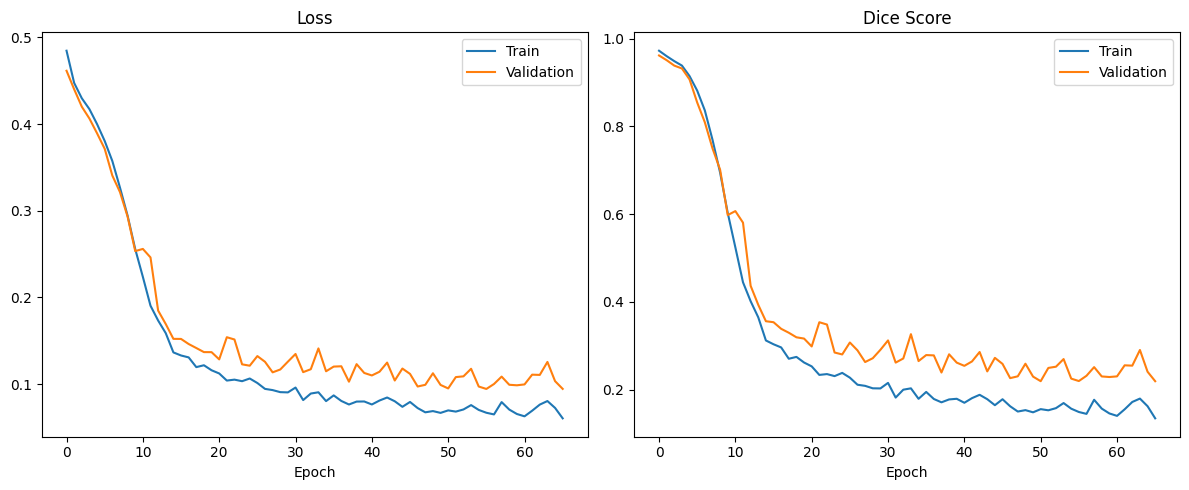

Evaluating: 100%|██████████| 589/589 [00:11<00:00, 51.64it/s]


Test Dice Score: 0.8768


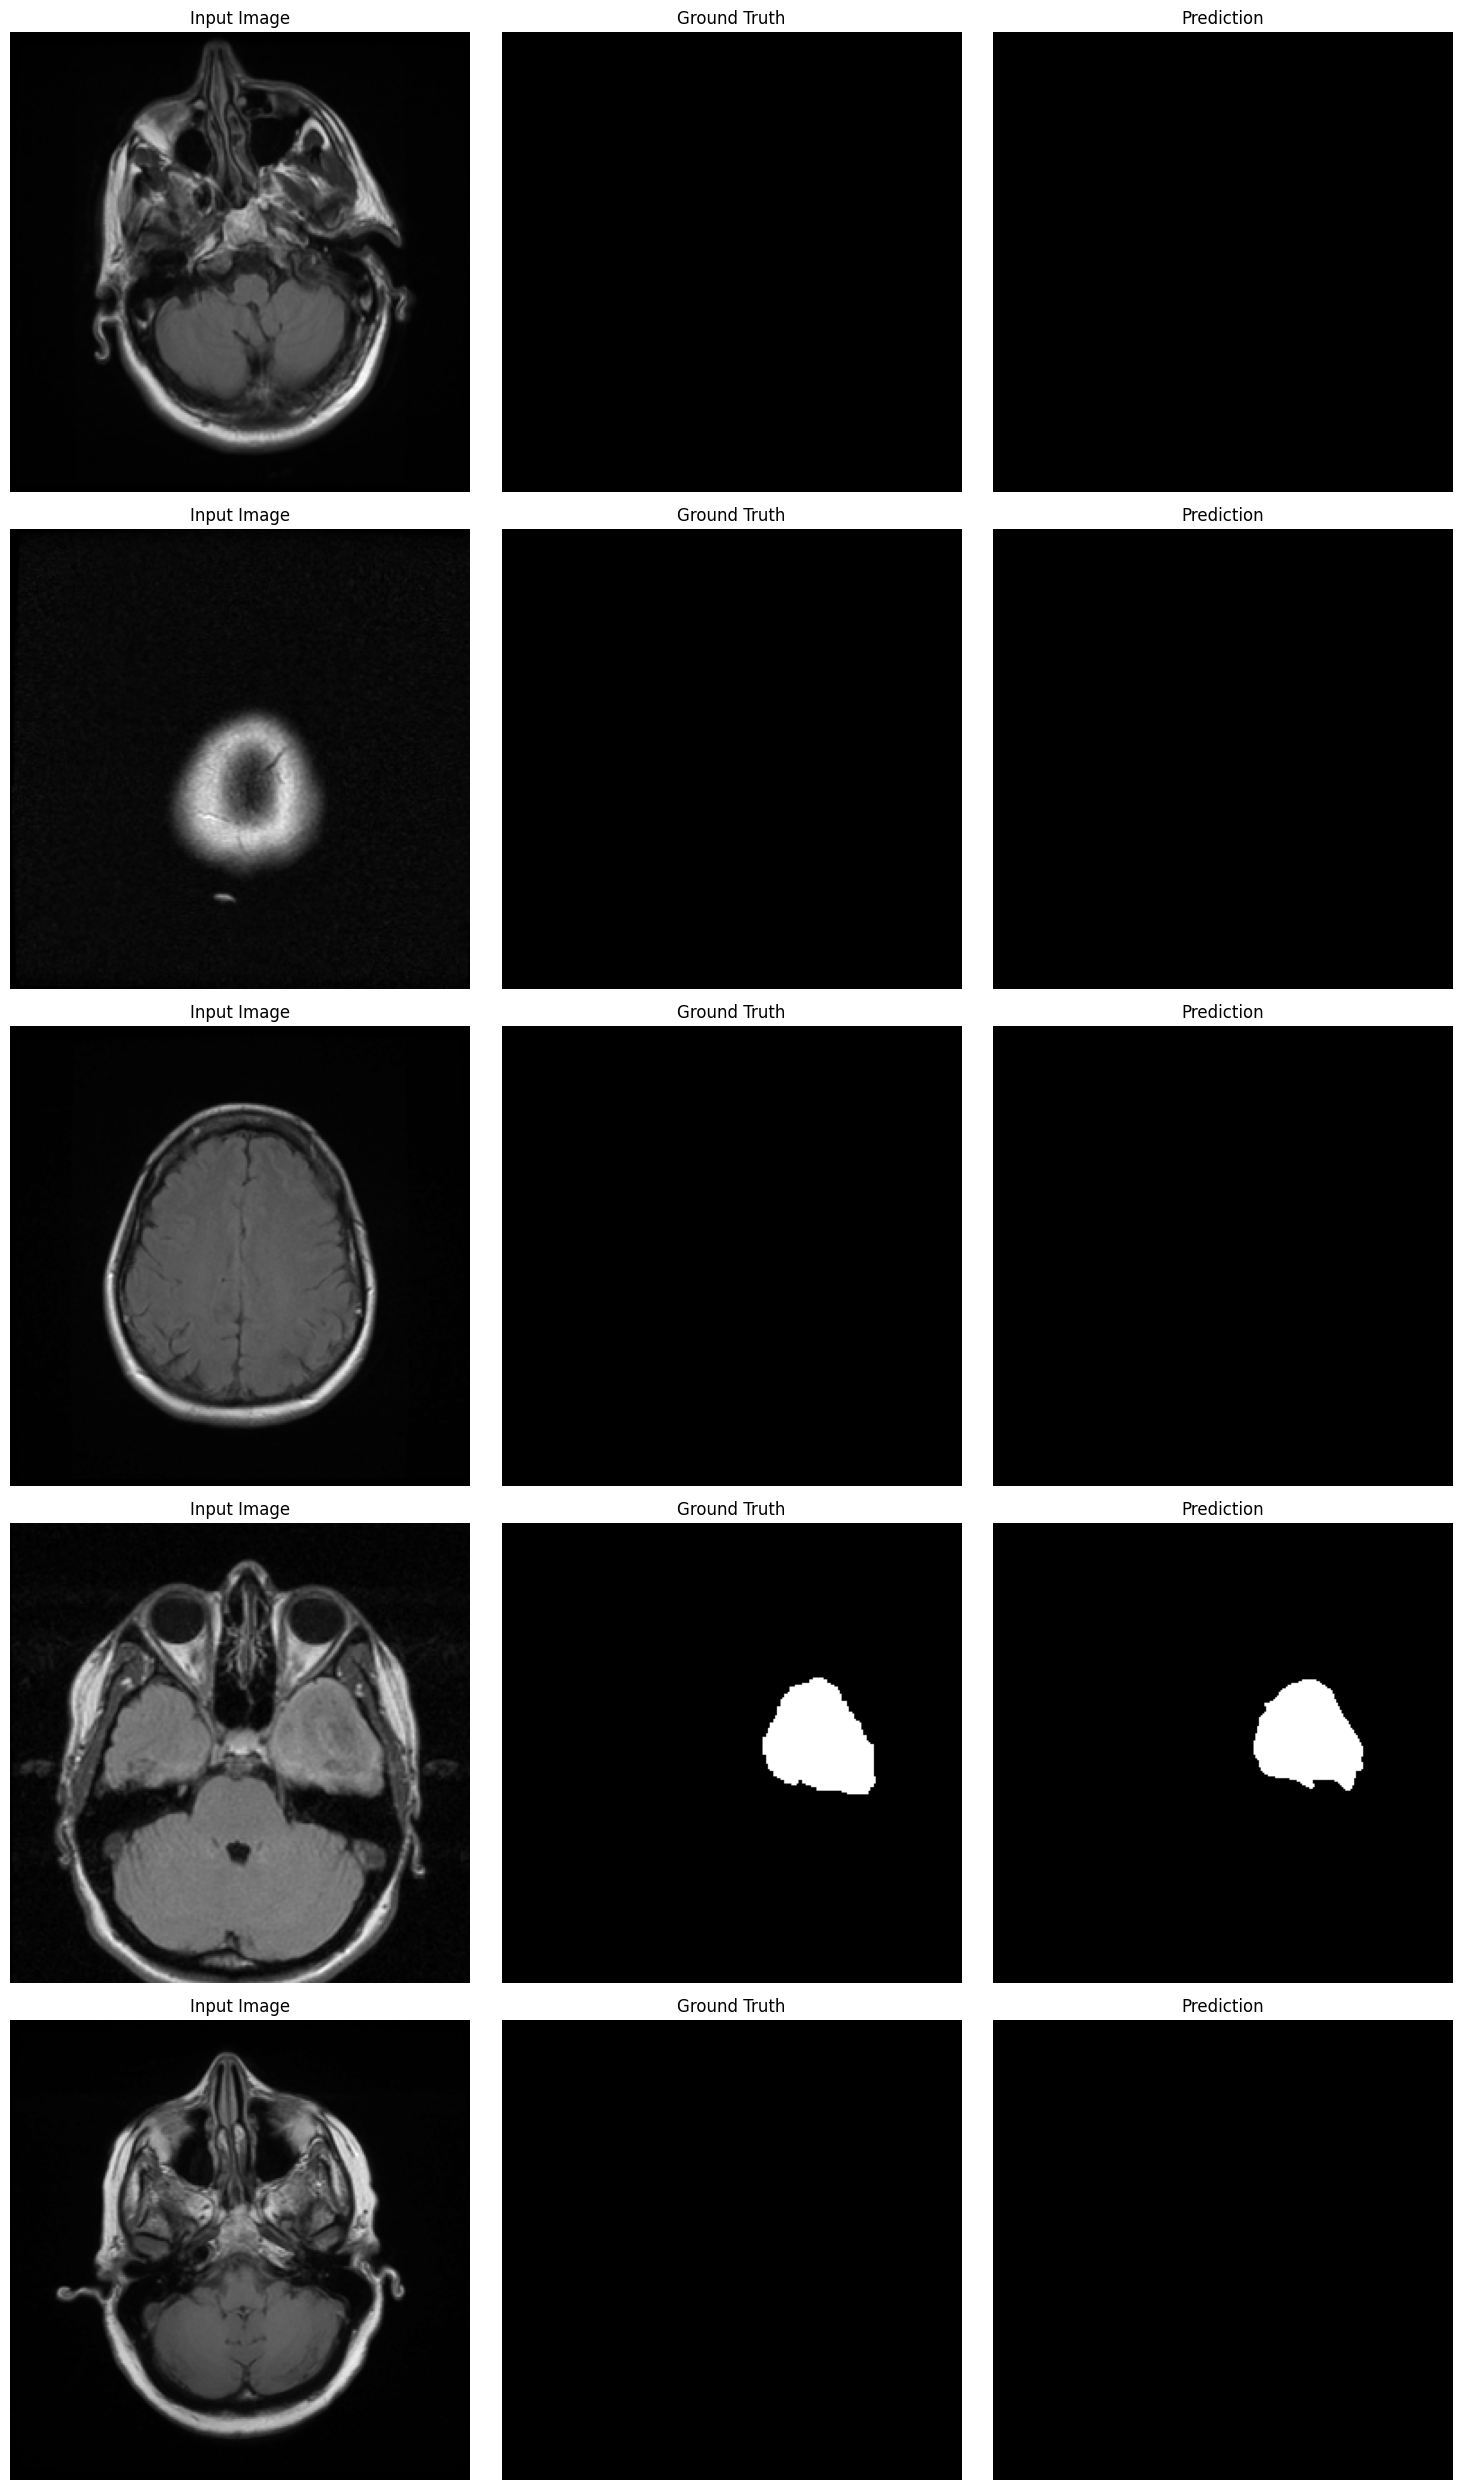

In [2]:
from segmentation import run_segmentation_pipeline

my_model = AttentionResUNet(in_channels=1, out_channels=1)

# Run the pipeline with custom model and naming
trained_model, dice_score = run_segmentation_pipeline(
    model=my_model,
    base_dir="kaggle_3m",
    model_name="Attresunet",
    batch_size=7,
    patience=10
)